![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)

**Author**: EUMETSAT <br>
**Copyright**: 2024 EUMETSAT <br>
**Licence**: MIT <br>

## Destination Earth - Climate Change Adaptation Digital Twin - Data Access using DEDL HDA

[Documentation DestinE Data Lake HDA](https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/dedl-discovery-and-data-access.html)

[Climate DT overview (for DESP testing period)](https://confluence.ecmwf.int/pages/viewpage.action?pageId=414254710)


<br>Author: EUMETSAT</br>

Credit: Earthkit and HDA Polytope used in this context are both packages provided by the European Centre for Medium-Range Weather Forecasts (**ECMWF**).

DEDL Harmonised Data Access is used in this example.</br>

## Obtain Authentication Token

In [16]:
import requests
import json
import os
from getpass import getpass
import destinelab as deauth

import importlib.metadata

### Query using the DEDL HDA API


First, we get an access token for the API

In [17]:
DESP_USERNAME = input("Please input your DESP username or email: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username or email:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


#### Check if DT access is granted

If DT access is not granted, you will not be able to execute the rest of the notebook.

In [18]:
installed_version = importlib.metadata.version("destinelab")
if(float(installed_version) >= 0.8):
    auth.is_DTaccess_allowed(access_token)

## Filter
We have to setup up a filter and define which data to obtain.

Choose a valid combination of => **Activity + Experiment + Model** (based on the year of interest)

Following **activities/experiment/model** & dates are possible:

ScenarioMIP/ssp3-7.0/ICON: Start date 20200101, 40 years<br> 
ScenarioMIP/ssp3-7.0/IFS-NEMO: Start date 20200101, 40 years<br> 

In [19]:
datechoice = "2028-06-10T00:00:00Z"
filters = {
    key: {"eq": value}
    for key, value in {
        "class": "d1",             # fixed 
        "dataset": "climate-dt",   # fixed climate-dt access
        "activity": "ScenarioMIP", # activity + experiment + model (go together)
        "experiment": "SSP3-7.0",  # activity + experiment + model (go together)
        "model": "IFS-NEMO",       # activity + experiment + model (go together)
        "generation": "1",         # fixed Specifies the generation of the dataset, which can be incremented as required (latest is 1)
        "realization": "1",        # fixed Specifies the climate realization. Default 1. Based on perturbations of initial conditions
        "resolution": "high",      # standard/ high 
        "expver": "0001",          # fixed experiment version 
        "stream": "clte",          # fixed climate
        "time": "0000",            # choose the hourly slot(s)
        "type": "fc",              # fixed forecasted fields
        "levtype": "sfc",          # Surface fields (levtype=sfc), Height level fields (levtype=hl), Pressure level fields (levtype=pl), Model Level (Levtype=ml)
#        "levelist": "1/2/3/...",  # for ml/pl/sol type data
        "param": "134"             # Surface Pressure parameter
    }.items()
}

## Make Data Request

In [20]:
response = requests.post("https://hda.data.destination-earth.eu/stac/search", headers=auth_headers, json={
 "collections": ["EO.ECMWF.DAT.DT_CLIMATE_ADAPTATION"],
    "datetime": datechoice,
    "query": filters
})

if(response.status_code!= 200):
    (print(response.text))
response.raise_for_status()
# Requests to EO.ECMWF.DAT.DT_CLIMATE always return a single item containing all the requested data
product = response.json()["features"][0]
product["id"]

'DT_CLIMATE_ADAPTATION_20280610_20280610_4d9849fd49038b27fb219cdfa53adf24d19b2cd8'

## Submission worked ? Once our product found, we download the data.

In [21]:
from IPython.display import JSON

# DownloadLink is an asset representing the whole product
download_url = product["assets"]["downloadLink"]["href"]
HTTP_SUCCESS_CODE = 200
HTTP_ACCEPTED_CODE = 202

direct_download_url=''

response = requests.get(download_url, headers=auth_headers)
if (response.status_code == HTTP_SUCCESS_CODE):
    direct_download_url = product['assets']['downloadLink']['href']
elif (response.status_code != HTTP_ACCEPTED_CODE):
    print(response.text)
print(download_url)
response.raise_for_status()    

https://hda.data.destination-earth.eu/stac/collections/EO.ECMWF.DAT.DT_CLIMATE_ADAPTATION/items/DT_CLIMATE_ADAPTATION_20280610_20280610_4d9849fd49038b27fb219cdfa53adf24d19b2cd8/download?provider=dedt_lumi&_dc_qs=%257B%2522activity%2522%253A%2B%2522ScenarioMIP%2522%252C%2B%2522class%2522%253A%2B%2522d1%2522%252C%2B%2522dataset%2522%253A%2B%2522climate-dt%2522%252C%2B%2522date%2522%253A%2B%252220280610%252Fto%252F20280610%2522%252C%2B%2522experiment%2522%253A%2B%2522SSP3-7.0%2522%252C%2B%2522expver%2522%253A%2B%25220001%2522%252C%2B%2522generation%2522%253A%2B1%252C%2B%2522levtype%2522%253A%2B%2522sfc%2522%252C%2B%2522model%2522%253A%2B%2522IFS-NEMO%2522%252C%2B%2522param%2522%253A%2B134%252C%2B%2522realization%2522%253A%2B1%252C%2B%2522resolution%2522%253A%2B%2522high%2522%252C%2B%2522stream%2522%253A%2B%2522clte%2522%252C%2B%2522time%2522%253A%2B0%252C%2B%2522type%2522%253A%2B%2522fc%2522%257D


## Wait until data is there

This data is not available at the moment. And we can see that our request is in `queued`status.  
We will now poll the API until the data is ready and then download it.

In [22]:
from tqdm import tqdm
import time
import re

# we poll as long as the data is not ready
if direct_download_url=='':
    while url := response.headers.get("Location"):
        print(f"order status: {response.json()['status']}")
        response = requests.get(url, headers=auth_headers, stream=True)

if (response.status_code not in (HTTP_SUCCESS_CODE,HTTP_ACCEPTED_CODE)):
     (print(response.text))

# Check if Content-Disposition header is present
if "Content-Disposition" not in response.headers:
    print(response)
    print(response.text)
    raise Exception("Headers: \n"+str(response.headers)+"\nContent-Disposition header not found in response. Must be something wrong.")
        
filename = re.findall('filename=\"?(.+)\"?', response.headers["Content-Disposition"])[0]
total_size = int(response.headers.get("content-length", 0))

print(f"downloading {filename}")

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filename, 'wb') as f:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            f.write(data)

order status: queued
downloading 69c82aba-637f-4a1b-9c6a-7a13f00cffd5.grib


100%|██████████| 23.6M/23.6M [00:00<00:00, 26.7MB/s]


## EarthKit

Lets plot the result file
[EarthKit Documentation] https://earthkit-data.readthedocs.io/en/latest/index.html

This section requires that you have `ecCodes >= 2.35` installed on your system.  
You can follow the installation procedure at https://confluence.ecmwf.int/display/ECC/ecCodes+installation

In [23]:
import earthkit.data
import earthkit.maps
import earthkit.regrid

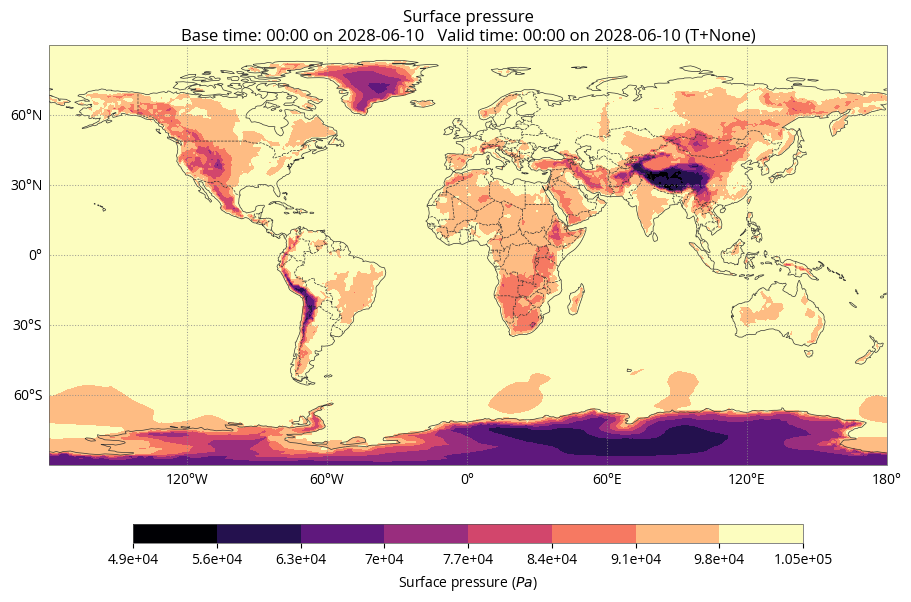

In [24]:
data = earthkit.data.from_source("file", filename)
data.ls
earthkit.maps.quickplot(data,#style=style
                       )